In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM, using both Adjusted Close and Volume Parameters
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Develop Stacked Model per DLNDF
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Merge
from keras.layers import Activation, Dropout
from keras.metrics import mean_squared_error
# Import fix for Tensorflow 1.0 control flow ops w/ Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_0

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter+1)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close  Volume
0     1  1995-01-03  30.707108  324300
1     2  1995-01-04  30.853865  351800
2     3  1995-01-05  30.853865   89800
3     4  1995-01-06  30.885254  448400
4     5  1995-01-09  30.916713   36800
---
      Item        Date   Adj_Close     Volume
5147  5148  2015-06-12  202.337412  135382400
5148  5149  2015-06-15  201.470299  124384200
5149  5150  2015-06-16  202.568649   85308200
5150  5151  2015-06-17  202.896224  126708600
5151  5152  2015-06-18  205.006216  165867900


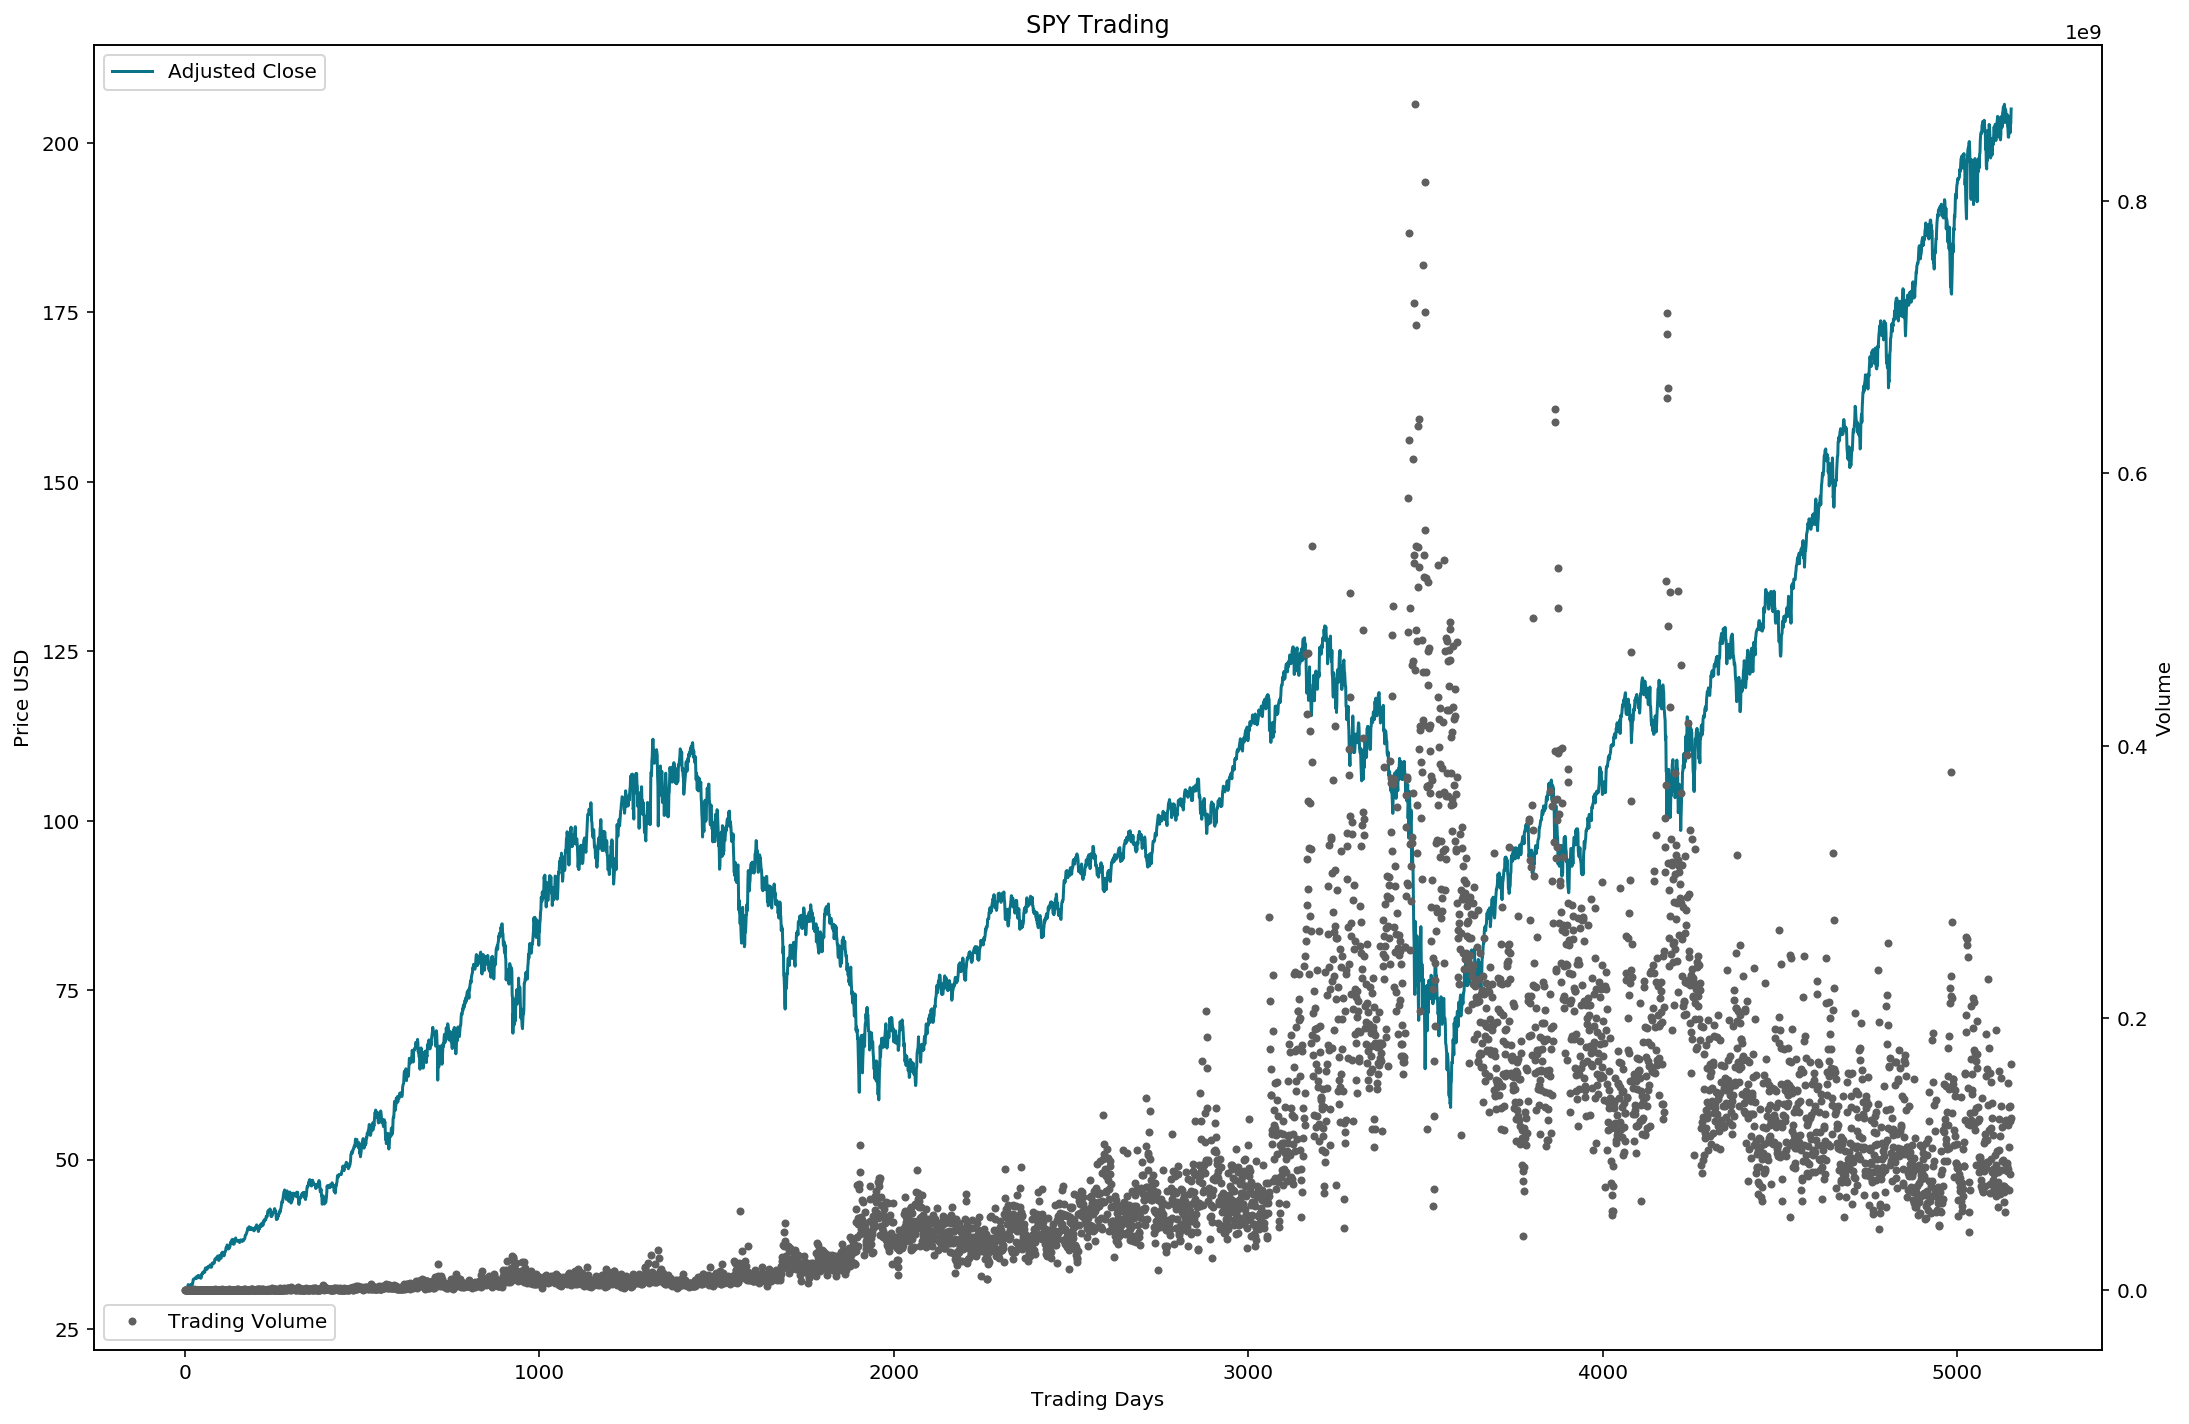

In [4]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

In [5]:
#Create numpy arrays for features and targets
day_all = []
vol_all = []
close_all = []

#Convert dataframe columns to numpy arrays 
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    day_all.append(row['Item'])
    vol_all.append(row['Volume'])
    close_all.append(row['Adj_Close'])

#pprint(X_all)
#pprint(close_all)

In [6]:
# Reshape into t and t+1
look_back = 3 #50
tt_split = (1.0-.315)
#X_day_train_t, X_day_train_t1, X_day_test_t, X_day_test_t1 = create_dataset(X_day_all, look_back, tt_split, True)
#X_vol_train_t, X_vol_train_t1 = create_dataset(X_vol_train, look_back, True)
X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)

pprint(X_close_train)
print('--')
pprint(y_close_train)

array([[[ 0.        ],
        [ 0.00083865],
        [ 0.00083865]],

       [[ 0.00083865],
        [ 0.00083865],
        [ 0.00101802]],

       [[ 0.00083865],
        [ 0.00101802],
        [ 0.00119779]],

       ..., 
       [[ 0.24519257],
        [ 0.25516354],
        [ 0.26131068]],

       [[ 0.25516354],
        [ 0.26131068],
        [ 0.27447625]],

       [[ 0.26131068],
        [ 0.27447625],
        [ 0.27394382]]])
--
array([ 0.00101802,  0.00119779,  0.00137755, ...,  0.27447625,
        0.27394382,  0.27694481])


In [7]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Define nodes per layer
n_nodes = [8,16]
# Create and fit the LSTM network
batch_size = 1
epochs = 1 # 200
# Create Stacked LSTM Network
model = Sequential()
model.add(LSTM(n_nodes[0],batch_input_shape=(batch_size, look_back, 1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_nodes[1],return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.2))
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='rmsprop')
print 'compilation time : ', time.time() - start


compilation time :  0.0870599746704


In [8]:
# Train the model
model.fit(
    X_close_train, 
    y_close_train,  
    nb_epoch=epochs, 
    batch_size=batch_size, 
    verbose=2, 
    validation_split=0.05)

Train on 3349 samples, validate on 177 samples
Epoch 1/1
24s - loss: 0.0026 - val_loss: 3.9517e-04


In [9]:
# Generate predictions for training
#testPredict = model.predict(X_close_test, batch_size=batch_size)
testPredict = util.predict_sequences(model, X_close_test)
pprint(testPredict)

[[0.27130038],
 [0.26990861],
 [0.26724845],
 [0.26018199],
 [0.25640047],
 [0.24894314],
 [0.24243627],
 [0.23861557],
 [0.23313586],
 [0.23087381],
 [0.22804959],
 [0.22255591],
 [0.22846314],
 [0.22658624],
 [0.22887743],
 [0.23355626],
 [0.23768198],
 [0.23833756],
 [0.22928822],
 [0.22599722],
 [0.22691552],
 [0.22975406],
 [0.23254384],
 [0.23904321],
 [0.24154823],
 [0.23607121],
 [0.22810858],
 [0.22860599],
 [0.22473963],
 [0.21723634],
 [0.20858569],
 [0.20632194],
 [0.20128424],
 [0.1975145],
 [0.19532329],
 [0.19963832],
 [0.19518462],
 [0.18749547],
 [0.17844874],
 [0.17166707],
 [0.17089261],
 [0.17017631],
 [0.16346797],
 [0.16544215],
 [0.17010544],
 [0.18164775],
 [0.18740129],
 [0.19432876],
 [0.19696428],
 [0.20126244],
 [0.20824334],
 [0.2093206],
 [0.20870179],
 [0.21226203],
 [0.22254373],
 [0.2215163],
 [0.22482024],
 [0.22407401],
 [0.21698458],
 [0.21304108],
 [0.21877685],
 [0.22643383],
 [0.23245029],
 [0.23180859],
 [0.22800939],
 [0.22751305],
 [0.23452146]

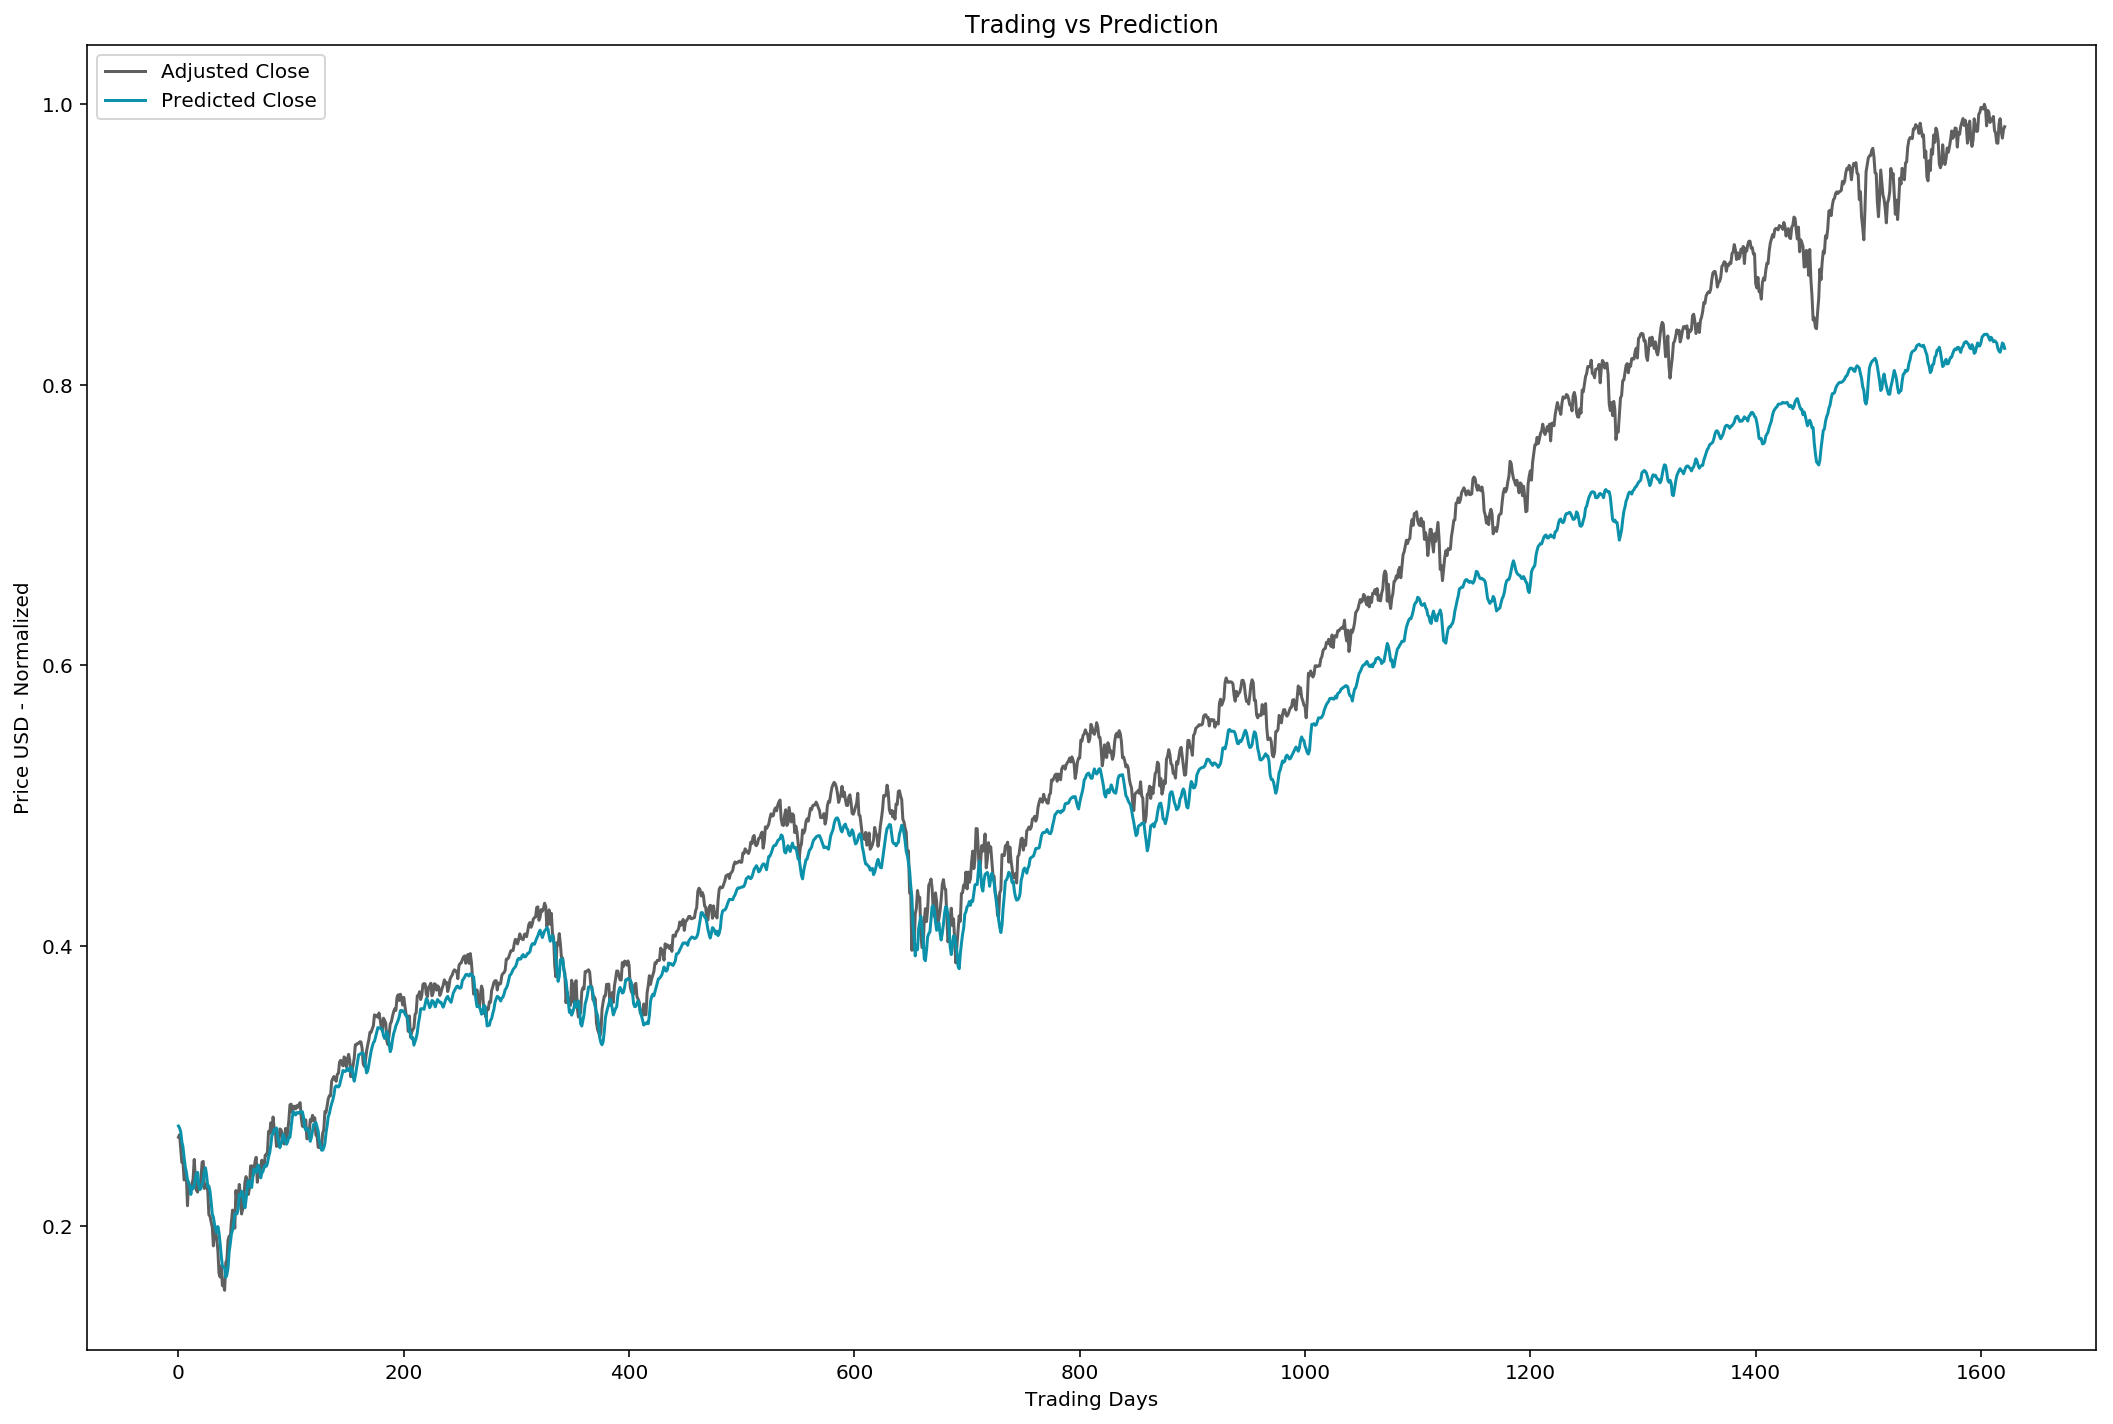

In [10]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [11]:
# The mean squared error
testScore = model.evaluate(X_close_test, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.0045 MSE (0.0668 RMSE)


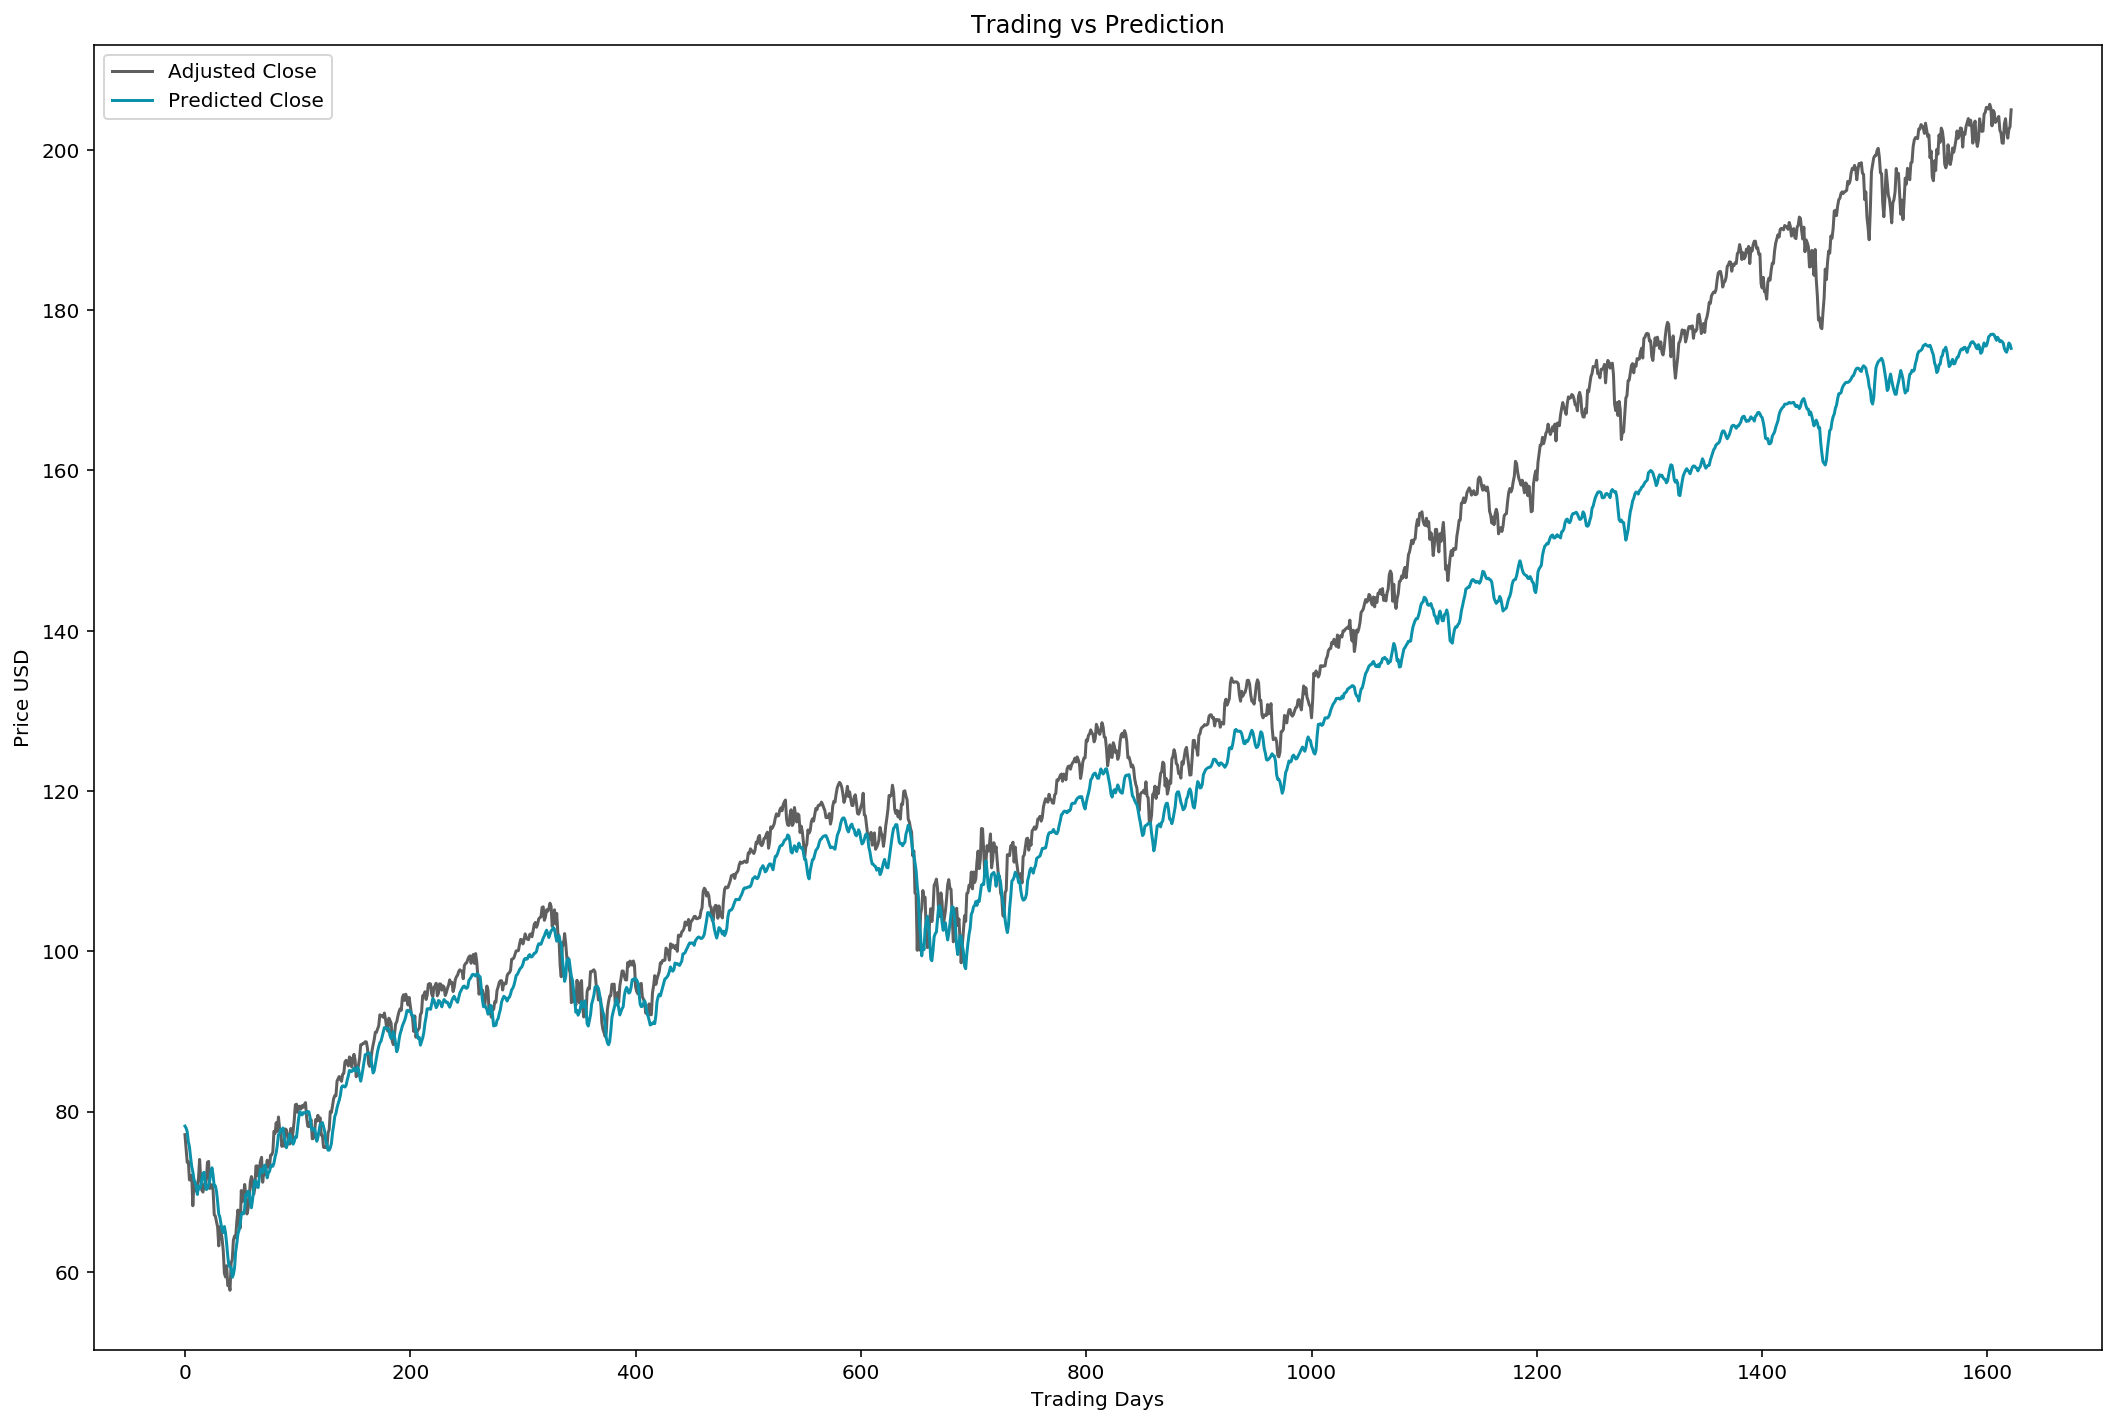

In [12]:
# Plot the predictions
close_plot = close_all[-y_close_test.shape[0]:]

pred_seq = np.array(testPredict)
#pprint(pred_seq)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

# Log of Results:
Epochs: 20

Dropout: 20%

### SPY
Lookback: 3 

LSTM = 8, Dense Layer1 = 1, Layer2 = Null, Layer3 = 1 

Test Score: 0.0047 MSE (0.0687 RMSE)


Lookback: 3 

LSTM = 3, LSTM = 100, Dense Layer1 = 1

Test Score: 0.0093 MSE (0.0965 RMSE)


Lookback: 3 

LSTM = 50, LSTM = 100, Dense Layer1 = 1

Test Score: 0.0171 MSE (0.1307 RMSE) rmsprop

Test Score: 0.0155 MSE (0.1245 RMSE) adam

Test Score: 0.0174 MSE (0.1321 RMSE) activation


Lookback: 30 

LSTM = 50, LSTM = 100, Dense Layer1 = 1

Test Score: 0.0177 MSE (0.1330 RMSE) 


Lookback: 3 

LSTM = 50, LSTM = 100, Dense Layer1 = 1



### GE
XX

### MSFT
XX

### AAPL
XX